## Part 3: Sentiment Analysis of the Country Music Network

This part covers the sentiment analysis of the country music network, addressing two main questions:
1. Calculate and analyze the sentiment of the Artists pages
2. Discuss the sentiment of the largest communities

### Initial Setup and Data
Only run these initial setup cells once as it takes an hour or so to fully execute...  
(Initial setup step 1 of 3): First we will import the necessary libraries and load our data.

In [ ]:
for name in dir():  #Remove all variable declarations from Part1 and Part2
    if not name.startswith('_'):
        del globals()[name]  #Wipe memory
import pandas as pd, numpy as np, pickle, json, re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import networkx as nx, community
import urllib3, requests
from urllib.parse import quote

(Initial setup step 2 of 3):  We fetch data from wikipedia (done as part of previous exercises. This takes roughly an hour)

In [ ]:
def fetch_country_musicians():
    http = urllib3.PoolManager()
    baseurl = "https://en.wikipedia.org/w/api.php?"
    query = f"{baseurl}action=query&titles=List_of_country_music_performers&prop=revisions&rvprop=content&format=json"
    wikiresponse = http.request('GET', query)
    wikijson = json.loads(wikiresponse.data.decode('utf-8'))
    wiki_text = json.dumps(wikijson["query"]["pages"])
    results = re.findall(r"\[\[(.*?)\]\]", wiki_text)
    cleaned_data = [name.replace(" ", "_") for name in results if not (name.startswith("File:") or name.startswith("Image:"))]
    return [name.replace("\\", "") for name in cleaned_data[1:]]
singers = fetch_country_musicians()

def fetch_wiki_content(singers):
    performer_text, performer_contents = {}, {}
    http = urllib3.PoolManager()
    for singer in singers:
        query = f"https://en.wikipedia.org/w/api.php?action=query&titles={quote(singer)}&prop=revisions&rvprop=content&format=json"
        try:
            if requests.get(query, timeout=10).status_code == 200:
                wikisource = http.request('GET', query).data.decode('utf-8')
                wiki_text = json.dumps(json.loads(wikisource)["query"]["pages"])
                performer_text[singer] = wiki_text
                performer_contents[singer] = [link.replace(" ", "_").replace("\\", "")
                    for link in re.findall(r"\[\[(.*?)\]\]", wiki_text)]
        except: pass
    return performer_text, performer_contents
performer_text, performer_contents = fetch_wiki_content(singers)

(Initial setup step 3 of 3):  We now create the graph, and along with the fetched wikipedia data we save it to disk such that we are able to quickly re-run the remaining cells of this notebook.

In [ ]:
def build_network(performer_contents):
    matches = [(performer, link) for performer, links in performer_contents.items()
              for link in links if link in performer_contents]
    G = nx.DiGraph()
    G.add_nodes_from(performer_contents.keys())
    G.add_edges_from(set(matches))
    return G

G = build_network(performer_contents)
G_undirected = G.to_undirected()
data_to_save = {
    'performer_text': performer_text,
    'performer_contents': performer_contents,
    'graph_directed': G,
    'graph_undirected': G_undirected,
    'content_size': [(p, len(re.findall(r'\w+', t))) for p, t in performer_text.items()]
}
with open('country_music_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)  #save data to disk for future code executions

### Part 3A: Sentiment Analysis of Artist Pages
> * Calculate the sentiment of the Artists pages and describe your findings using stats and visualization.

We have downloaded the LabMT wordlist from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) as described in the week 8 exercise. We now read it as a pandas dataframe.
We'll use it to calculate sentiment scores for each artist's Wikipedia page.

In [108]:
for name in dir():  #Remove all variable declarations from Part1, Part2 and Part3 initial setup
    if not name.startswith('_'):
        del globals()[name]  #Wipe memory
import pandas as pd, numpy as np, pickle, json, re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import networkx as nx, community
import urllib3, requests
from urllib.parse import quote

with open('country_music_data.pkl', 'rb') as f:  #check the cells above to see how we generated this
    musicians_data = pickle.load(f)  #load our network with Wikipedia data
artist_texts = musicians_data['performer_text']
G = musicians_data['graph_directed']
G_undirected = musicians_data['graph_undirected']

labmt_df = pd.read_csv('LabMT_data.txt', sep='\t', na_values='--')  #Read LabMT temporal patterns word list

Now we'll calculate sentiment scores for all artists and analyze the distribution. Note that we are using the full set of artists for our analysis.  
  
Some artists have missing or very little wikitext (or the page is simply a redirect). Because of this, we only calculate the sentiment for artists with a wikitext of more than 500 characters, as this gives a more meaningful ranking of the highest and lowest sentiment artists.

In [109]:
#This cell might take a few minutes to execute.
def create_sentiment_dict(df):
    return dict(zip(df['word'], df['happiness_average']))

def calculate_sentiment(text, sentiment_dict):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        scores = [sentiment_dict[word] for word in tokens if word in sentiment_dict]
        return np.mean(scores) if scores else None
    return None

artist_sentiments = {}
sentiment_dict = create_sentiment_dict(labmt_df)
counted_artists = 0
for artist, text in artist_texts.items():
    sentiment = calculate_sentiment(text, sentiment_dict)
    if sentiment is not None and len(text) > 500:
        counted_artists += 1
        artist_sentiments[artist] = sentiment
print(f"{counted_artists} of {len(artist_texts.items())} artists have a wikitext greater than 500 characters ({counted_artists*100/len(artist_texts.items()):.1f} %)")

2047 of 2105 artists have a wikitext greater than 500 characters (97.2 %)


Finally, we're done! Now we can get started with the fun stuff...  
  
Let's generate some statistics to see which artists have the highest and lowest sentiment scores...

In [110]:
sentiments = list(artist_sentiments.values())
highest_sentiment_artist = max(artist_sentiments.items(), key=lambda x: x[1])
lowest_sentiment_artist = min(artist_sentiments.items(), key=lambda x: x[1])
top_5_highest = sorted(artist_sentiments.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_lowest = sorted(artist_sentiments.items(), key=lambda x: x[1])[:5]

print()
stats = {
    'mean': np.mean(sentiments),
    'median': np.median(sentiments),
    'std': np.std(sentiments),
    '25th': np.percentile(sentiments, 25),
    '75th': np.percentile(sentiments, 75),
}
print("Sentiment Statistics:")
for stat_name, value in stats.items():
    print(f"{stat_name}: {value:.3f}")

print("\nTop 5 highest sentiment artists:")
for artist, sentiment in top_5_highest:
    print(f"{artist}: {sentiment:.3f}")

print("\nTop 5 lowest sentiment artists:")
for artist, sentiment in top_5_lowest:
    print(f"{artist}: {sentiment:.3f}")


Sentiment Statistics:
mean: 5.654
median: 5.653
std: 0.091
25th: 5.593
75th: 5.711

Top 5 highest sentiment artists:
Troy_Cassar-Daley: 5.975
McAlister_Kemp: 5.964
Jeff_Knight_(musician)|Jeff_Knight: 5.953
Adam_Harvey: 5.949
Jennifer_Day: 5.947

Top 5 lowest sentiment artists:
Those_Poor_Bastards: 5.279
Stonewall_Jackson_(musician)|Stonewall_Jackson: 5.324
Ricochet_(band)|Ricochet: 5.358
Tex_Williams: 5.401
David_"Stringbean"_Akeman: 5.407


From our analysis it appears that Troy_Cassar-Daley is the artist with the most positive/happy/uplifting stentiment (sentiment score of 5.975).  
  
Additionally, Those_Poor_Bastards is the artist with the most negative/sad/downbeat stentiment (sentiment score of 5.279). Their band name may perhaps be the reason for this?
  
Again, remember that we only calculate the sentiment for artists with a wikitext of more than 500 characters. We have put this filter in place in order to avoid empty near-empty pages dominating the Top 5 and Bottom 5 sortings.

However, let's not focus too much on the outliers. It can be hard to see the bigger picture only from summary statistics, so let's also visualize the distribution of sentiments across all artists.

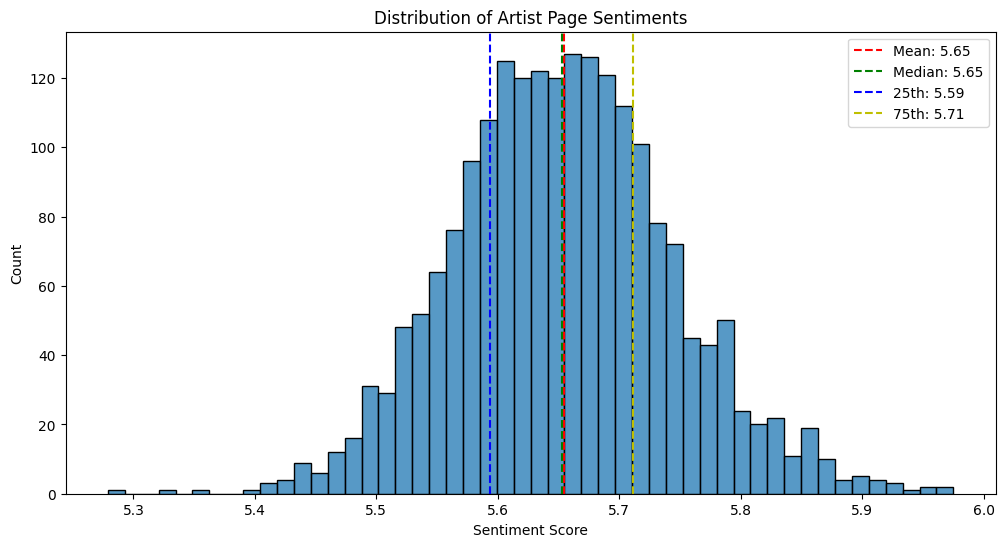

In [111]:
plt.figure(figsize=(12, 6))
sns.histplot(sentiments, bins=50)
plt.axvline(stats['mean'], color='r', linestyle='--', label=f"Mean: {stats['mean']:.2f}")
plt.axvline(stats['median'], color='g', linestyle='--', label=f"Median: {stats['median']:.2f}")
plt.axvline(stats['25th'], color='b', linestyle='--', label=f"25th: {stats['25th']:.2f}")
plt.axvline(stats['75th'], color='y', linestyle='--', label=f"75th: {stats['75th']:.2f}")
plt.title('Distribution of Artist Page Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend()
plt.show()

We see that the sentiment distribution follows a bell curve that is (mostly) symmetrical around the middle. Based on the visualization, we have reason to believe that all the artists more or less share the same general sentiment, but with natural variance (super happy or super sad artists do not appear more frequently that expected).
  
In terms of simply summary statistics, the mean is 5.654, the median is 5.653 and the standard deviation is 0.091.

### Part 3B: Sentiment Analysis of Largest Communities
> * Discuss the sentiment of the largest communities. Do the findings using TF-IDF help you understand your results?  
  
Now we'll analyze the sentiment distribution across different communities in the network.  
  
We will start off by loading the genres data for each artist (credit to Aliaksandr)

In [ ]:
with open('w7_data.txt', 'r') as f:  #file uploaded by TA Aliaksandr
    genre_data = json.load(f)

def get_all_genres(genre_data):
    genre_communities = {}
    for artist, genres in genre_data.items():
        for genre in genres:
            if genre not in genre_communities:
                genre_communities[genre] = []
            genre_communities[genre].append(artist)
    #to only get the largest communities, we filter out genres with fewer than 80 artists
    filtered_genre_communities = {genre: artists for genre, artists in genre_communities.items()
                                if len(artists) >= 80}
    return filtered_genre_communities
genre_communities = get_all_genres(genre_data)

def clean_artist_name(raw_name):  #ensure the key name matches the formatting used by Aliaksandr
    name = re.sub(r'\(.*?\)', '', raw_name)
    name = name.split(" (")[0]
    name = name.split('|')[0]
    name = name.replace('_', ' ').strip()
    return name
cleaned_artist_sentiments = {clean_artist_name(key): value for key, value in artist_sentiments.items()}
cleaned_artist_texts = {clean_artist_name(key): value for key, value in artist_texts.items()}

Note that we have filtered out genres with fewer than 80 artist. This is done to only focus on the largest communities.  
  
We now calculate the sentiment for each genre community.

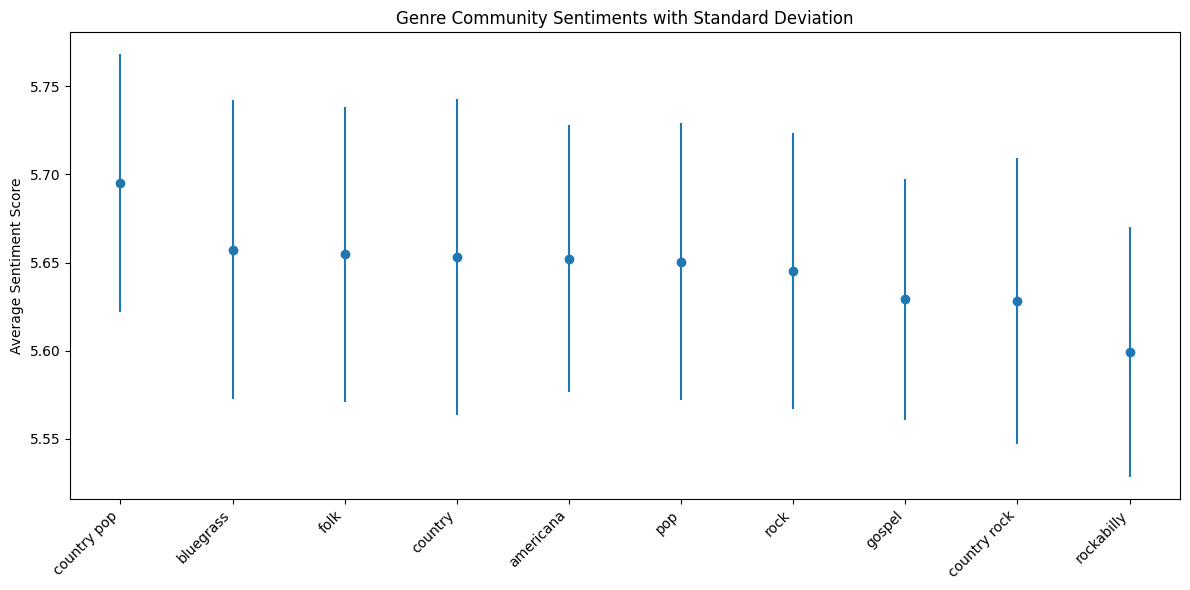


Genre Community Sentiments:
country pop: 5.695 (±0.073), size: 109
bluegrass: 5.657 (±0.085), size: 126
folk: 5.655 (±0.084), size: 174
country: 5.653 (±0.090), size: 1479
americana: 5.652 (±0.076), size: 153
pop: 5.650 (±0.078), size: 154
rock: 5.645 (±0.078), size: 115
gospel: 5.629 (±0.068), size: 94
country rock: 5.628 (±0.081), size: 165
rockabilly: 5.599 (±0.071), size: 79


In [359]:
import numpy as np
genre_sentiments = {}
for genre, artists in genre_communities.items():
    genre_scores = [cleaned_artist_sentiments[clean_artist_name(artist)]
                    for artist in artists if clean_artist_name(artist) in cleaned_artist_sentiments]
    if genre_scores:
        genre_sentiments[genre] = {
            'sentiment': np.mean(genre_scores),  #average sentiment score
            'size': len(genre_scores),           #number of artists with sentiment scores
            'std': np.std(genre_scores)          #standard deviation of the sentiment scores
        }

sorted_genres = sorted(genre_sentiments.items(),
                       key=lambda x: x[1]['sentiment'],
                       reverse=True)
plt.figure(figsize=(12, 6))
genres = [g[0] for g in sorted_genres]
sentiments = [g[1]['sentiment'] for g in sorted_genres]
errors = [g[1]['std'] for g in sorted_genres]
plt.errorbar(range(len(genres)), sentiments, yerr=errors, fmt='o')
plt.xticks(range(len(genres)), genres, rotation=45, ha='right')
plt.title('Genre Community Sentiments with Standard Deviation')
plt.ylabel('Average Sentiment Score')
plt.tight_layout()
plt.show()
print("\nGenre Community Sentiments:")
for genre, stats in sorted_genres:
    print(f"{genre}: {stats['sentiment']:.3f} (±{stats['std']:.3f}), size: {stats['size']}")



Above we can see a comparison between the sentiment of the 10 biggest communities. Country pop has the highest sentiment, whereas rockabilly has the lowest sentiment. However the difference is somewhat small and not significant.   
  
We will now do TF-IDF analysis to get a deeper understanding.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
custom_stop_words = [  #we define a custom set of stop words that are frequent but not meaningful
    'ref', 'date', 'com', 'url', 'title', 'web', 'cite',
    'www', 'http', 'https', 'archive', 'width', 'align',
    'center', 'scope', '01', 'album', 'band', 'english',
    'access', 'category', 'org',
]

genre_texts = {}  # Combine texts for each genre
for genre, artists in genre_communities.items():
    texts = [cleaned_artist_texts[clean_artist_name(artist)] for artist in artists if clean_artist_name(artist) in cleaned_artist_texts]
    genre_texts[genre] = ' '.join(texts)
vectorizer = TfidfVectorizer(max_features=1000, stop_words=custom_stop_words)
tfidf_matrix = vectorizer.fit_transform(genre_texts.values())
feature_names = vectorizer.get_feature_names_out()

for genre, text_idx in zip(genre_texts.keys(), range(len(genre_texts))):
    tfidf_scores = tfidf_matrix[text_idx].toarray()[0]
    top_indices = tfidf_scores.argsort()[-20:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    print(f"Top terms for {genre}:")
    print(', '.join(top_terms))

Top terms for country:
the, and, of, in, country, to, music, on, name, was, with, for, u2014, his, first, style, at, billboard, news, he
Top terms for country rock:
the, and, of, in, to, country, music, on, was, with, name, for, news, first, his, at, from, as, billboard, magazine
Top terms for folk:
the, and, of, in, to, music, on, name, with, was, for, country, first, his, u2014, at, news, magazine, as, he
Top terms for gospel:
the, of, and, in, to, music, country, on, was, with, for, name, his, at, he, first, her, as, news, by
Top terms for pop:
the, and, of, in, to, music, on, news, for, with, name, was, first, magazine, billboard, status, country, her, live, last
Top terms for bluegrass:
the, of, and, in, to, music, name, country, on, with, for, was, bluegrass, at, as, first, from, his, year, by
Top terms for rock:
the, and, of, in, to, music, on, with, name, for, was, first, news, magazine, his, last, style, as, billboard, at
Top terms for rockabilly:
the, and, of, in, to, was, on

*Discussion*  
  
The TF-IDF results show overlap in common terms ("the", "of", "and", "in") across genres, this is to be expected.  
    
The more traditional genres (Rockabilly, Gospel, Country Rock) have slightly lower sentiment scores than the commercially successful genres (Country Pop, Pop, Rock), which may be due to the emotion surrounding the artist and the music.  
  
However, we can see that the sentiment is overall positive for all the genres and the differences between genres are relatively small (range from 5.599 to 5.695). So this difference is mostly nitpicking, and with such a small difference in sentiment we shouldn't expect a big difference in the sentiment of the most common words.  

Finally, it should be noted that we needed to set up a word filter to filter out words such as 'www', 'http' and 'ref'. If we did not do this, the top terms would be wikitext syntax and similar web keywords. This means that we did not properly clean the data before running our analysis, which may have impacted the results.